In [16]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

plt.rcParams['figure.figsize'] = [12,10]
plt.rcParams['image.cmap'] = "gray"

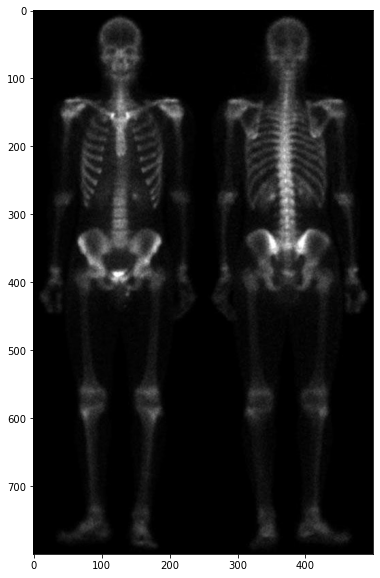

In [17]:
img_path = "../images/Fig0343(a)(skeleton_orig).tif"

img = cv2.imread(img_path, 0)

plt.imshow(img, cmap="gray")

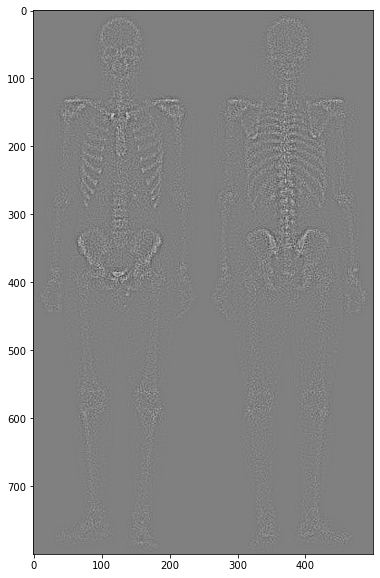

In [18]:
# laplacian 

kernel = np.array([[-1 , -1, -1],
                   [-1, 8, -1], 
                  [-1, -1, -1]])

laplacian_image = cv2.filter2D(img, cv2.CV_64F, kernel)

plt.imshow(laplacian_image, cmap="gray")

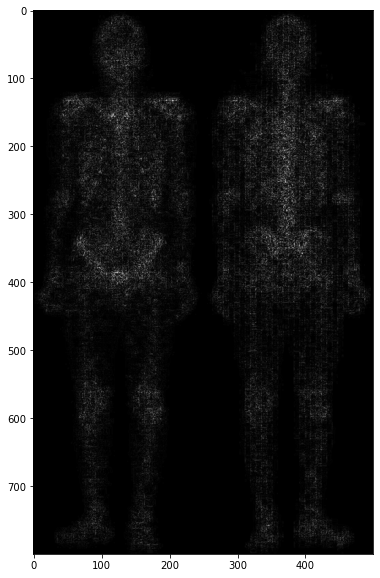

In [19]:
laplacian_abs = np.absolute(laplacian_image)
laplacian_normalized = np.uint8(255 * laplacian_abs / np.max(laplacian_abs))

plt.imshow(laplacian_normalized, cmap="gray")

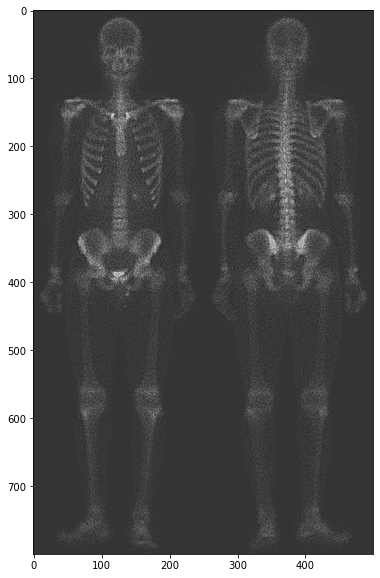

In [20]:
# adding image to laplacian output 

fig_c = laplacian_image + img 

plt.imshow(fig_c, cmap="gray")

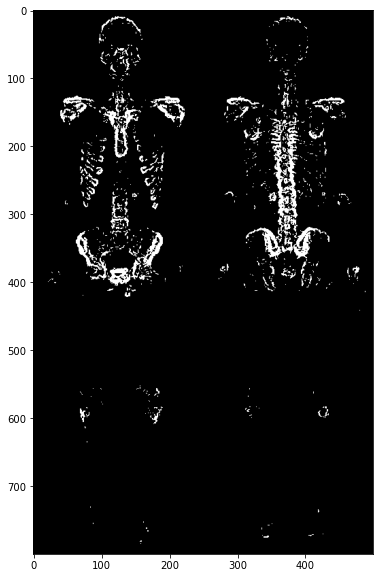

In [37]:
threshold_ratio=0.2

# sobel gradient 
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

# Compute the magnitude of the gradients
# Using absolute values for simplicity
gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)

gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)

threshold = threshold_ratio * np.max(gradient_magnitude)
edge_mask = (gradient_magnitude > threshold).astype(np.float32)

plt.imshow(edge_mask)

## Figure 3.57

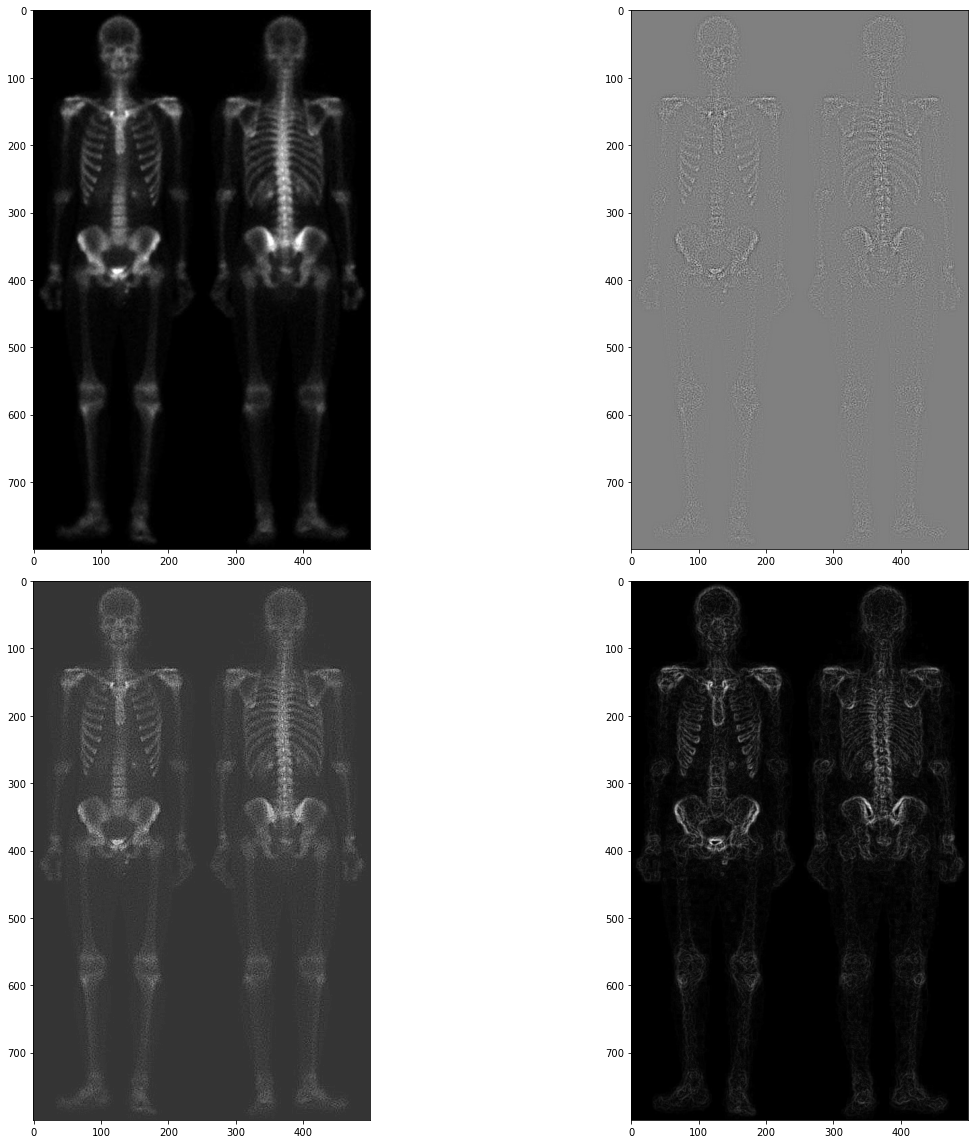

In [22]:
plt.figure(figsize = (20,16))

plt.subplot(221)
plt.imshow(img, cmap="gray")

plt.subplot(222)
plt.imshow(laplacian_image, cmap="gray")

plt.subplot(223)
plt.imshow(fig_c, cmap="gray")

plt.subplot(224)
plt.imshow(magnitude_abs, cmap="gray")

plt.tight_layout()
plt.show()

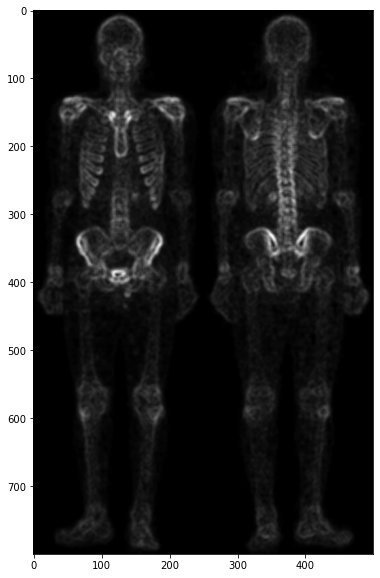

In [23]:
# blurred gradient image 

kernel = (1/25)*np.ones((5,5))

box_blurred_image = cv2.filter2D(magnitude_abs, -1, kernel)

plt.imshow(box_blurred_image)

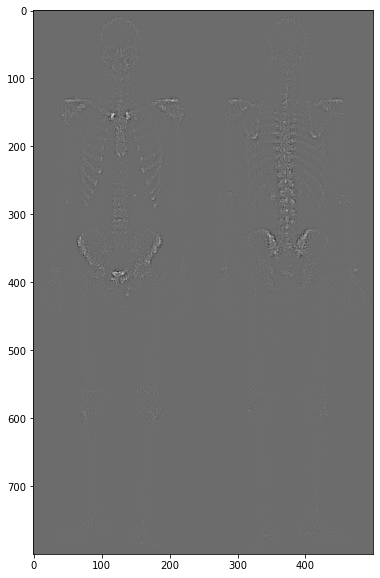

In [24]:
# mask image 

mask_image = laplacian_image*box_blurred_image

plt.imshow(mask_image)

Not getting the expected output

In [38]:
def enhance_with_masked_laplacian(image_path, kernel_size=3, threshold_ratio=0.2, laplacian_scale=0.5):
    """
    Enhance an image with narrow dynamic range using masked Laplacian.
    
    Parameters:
    -----------
    image_path : str
        Path to the input image
    kernel_size : int
        Size of the kernel for Gaussian blur (must be odd)
    threshold_ratio : float
        Ratio of max gradient magnitude to use as threshold for edge mask
    laplacian_scale : float
        Scaling factor for the Laplacian enhancement
        
    Returns:
    --------
    tuple
        (original image, enhanced image, edge mask, laplacian result)
    """
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE) if len(img.shape) > 2 else img.copy()
    
    # Create a smoothed version of the image to reduce noise
    smoothed = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    
    # Calculate the gradients using Sobel operators
    grad_x = cv2.Sobel(smoothed, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(smoothed, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate gradient magnitude
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Normalize gradient magnitude to [0, 1]
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 1, cv2.NORM_MINMAX)
    
    # Create a binary mask using a threshold
    threshold = threshold_ratio * np.mdiax(gradient_magnitude)
    edge_mask = (gradient_magnitude > threshold).astype(np.float32)
    
    # Optional: Clean up the mask
    edge_mask = cv2.morphologyEx(edge_mask, cv2.MORPH_CLOSE, 
                                np.ones((3, 3), np.uint8))
    
    # Apply Laplacian filter to detect edges
    laplacian = cv2.Laplacian(gray, cv2.CV_64F, ksize=3)
    
    # Normalize Laplacian result to avoid overflow
    laplacian_norm = cv2.normalize(laplacian, None, 0, 1, cv2.NORM_MINMAX)
    
    # Apply the edge mask to the Laplacian result
    masked_laplacian = laplacian_norm * edge_mask
    
    # Create the enhanced image by adding the masked Laplacian to the original
    # Grayscale image
    img_float = gray.astype(np.float32) / 255.0
    enhanced = img_float + laplacian_scale * masked_laplacian
    enhanced = np.clip(enhanced, 0, 1)
    enhanced = (enhanced * 255).astype(np.uint8)
    
    return img, enhanced, edge_mask, laplacian_norm

In [26]:
def display_results(original, enhanced, edge_mask, laplacian):
    """Display the original image, edge mask, and enhanced image."""
    plt.figure(figsize=(16, 12))
    
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.title('Edge Mask')
    plt.imshow(edge_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.title('Laplacian Result')
    plt.imshow(laplacian, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.title('Enhanced Image (Masked Laplacian)')
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [12]:
def compare_standard_vs_masked(image_path, kernel_size=3, threshold_ratio=0.2, laplacian_scale=0.5):
    """Compare standard Laplacian enhancement vs masked Laplacian enhancement."""
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE) if len(img.shape) > 2 else img.copy()
    
    # Apply standard Laplacian enhancement
    laplacian = cv2.Laplacian(gray, cv2.CV_64F, ksize=3)
    laplacian_norm = cv2.normalize(laplacian, None, 0, 1, cv2.NORM_MINMAX)
    
    # Standard enhancement (adding Laplacian to original)
    if len(img.shape) > 2:  # Color image
        img_float = img.astype(np.float32) / 255.0
        standard_enhanced = np.zeros_like(img_float)
        for i in range(3):
            standard_enhanced[:,:,i] = img_float[:,:,i] + laplacian_scale * laplacian_norm
        standard_enhanced = np.clip(standard_enhanced, 0, 1)
        standard_enhanced = (standard_enhanced * 255).astype(np.uint8)
    else:
        img_float = gray.astype(np.float32) / 255.0
        standard_enhanced = img_float + laplacian_scale * laplacian_norm
        standard_enhanced = np.clip(standard_enhanced, 0, 1)
        standard_enhanced = (standard_enhanced * 255).astype(np.uint8)
    
    # Get masked Laplacian enhancement
    _, masked_enhanced, edge_mask, _ = enhance_with_masked_laplacian(
        image_path, kernel_size, threshold_ratio, laplacian_scale
    )
    
    # Display comparison
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Standard Laplacian Enhancement')
    plt.imshow(cv2.cvtColor(standard_enhanced, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Masked Laplacian Enhancement')
    plt.imshow(cv2.cvtColor(masked_enhanced, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [14]:

# Example usage
if __name__ == "__main__":
    # You can replace this with your own image path
    
    try:
        # Process the image with masked Laplacian
        original, enhanced, edge_mask, laplacian = enhance_with_masked_laplacian(
            img_path, 
            kernel_size=5,
            threshold_ratio=0.2,
            laplacian_scale=0.5
        )
        
        # Display the results
        display_results(original, enhanced, edge_mask, laplacian)
        
        # Compare standard vs masked Laplacian enhancement
        compare_standard_vs_masked(image_path)
        
    except Exception as e:
        print(f"Error: {e}")
        print("Please provide a valid image path.")

Error: operands could not be broadcast together with shapes (800,500) (800,500,4) 
Please provide a valid image path.
